Importando o dataset dos dados de agressao textual.

In [4]:
import pandas as pd

data_frame = pd.read_csv('./dados/aggression_parsed_dataset.csv')
print(data_frame.head())

   index                                               Text  ed_label_0  \
0      0  `- This is not ``creative``.  Those are the di...    0.900000   
1      1  `  :: the term ``standard model`` is itself le...    1.000000   
2      2    True or false, the situation as of March 200...    1.000000   
3      3   Next, maybe you could work on being less cond...    0.555556   
4      4               This page will need disambiguation.     1.000000   

   ed_label_1  oh_label  
0    0.100000         0  
1    0.000000         0  
2    0.000000         0  
3    0.444444         0  
4    0.000000         0  


Removendo varias que nao vou utilizar

In [7]:
data_frame = data_frame.drop(['index', 'ed_label_0', 'ed_label_1'], axis=1)
print(data_frame.head())

                                                Text  oh_label
0  `- This is not ``creative``.  Those are the di...         0
1  `  :: the term ``standard model`` is itself le...         0
2    True or false, the situation as of March 200...         0
3   Next, maybe you could work on being less cond...         0
4               This page will need disambiguation.          0


Verificando quantidade de items por classe

In [8]:
quantity_by_class = data_frame.groupby('oh_label').size()
print(quantity_by_class)

oh_label
0    101082
1     14782
dtype: int64


Separando a quantidade de items para treino, validacao e teste

In [38]:
from sklearn.model_selection import train_test_split
import numpy as np

# Separar em conjunto de teste (30%)
train_temp, test = train_test_split(data_frame, test_size=0.3)

# Separar o conjunto de treinamento em conjunto de treinamento final (60%) e conjunto de validação (10%)
train, validation_temp = train_test_split(train_temp, test_size=0.1667, stratify=train_temp['oh_label'])

# Calcular o tamanho mínimo desejado para cada classe no conjunto de treinamento
min_items_per_class = 10000  # Defina o número mínimo de itens desejado por classe

# Obter a contagem de itens por classe no conjunto de treinamento
class_counts = train['oh_label'].value_counts()

# Calcular o tamanho mínimo entre as classes
min_class_size = np.min([class_counts[class_label] if class_label in class_counts else 0 for class_label in train['oh_label'].unique()])

# Usar o tamanho mínimo desejado se for menor que o tamanho mínimo entre as classes
min_class_size = min(min_items_per_class, min_class_size)

# Reagrupar para ter o número igual de itens por classe no conjunto de treinamento
train = train.groupby('oh_label').apply(lambda x: x.sample(n=min(len(x), min_class_size))).reset_index(drop=True)

# Converter a variável train em um DataFrame do Pandas
train = pd.DataFrame(train)
validation_temp = pd.DataFrame(validation_temp)
test = pd.DataFrame(test)

# Exibir o número de itens em cada conjunto
print("Tamanho do conjunto de treinamento:", len(train))
print("Tamanho do conjunto de validação:", len(validation_temp))
print("Tamanho do conjunto de teste:", len(test))

quantity_train_group_by_class = train.groupby('oh_label').size()
print(f"\n {quantity_train_group_by_class}")

Tamanho do conjunto de treinamento: 17272
Tamanho do conjunto de validação: 13521
Tamanho do conjunto de teste: 34760

 oh_label
0    8636
1    8636
dtype: int64


Normalizando as frases

In [46]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string


# Definir as funções para tokenização e normalização
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token.lower() for token in tokens]
    return tokens

def normalize_text(tokens):
    stopwords_list = stopwords.words('english')  # Usar o idioma inglês para stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_list]
    return tokens

# Verificar se os recursos do NLTK estão disponíveis, caso contrário, fazer o download
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)
    
    
# Aplicar as funções de tokenização e normalização aos dados do DataFrame
train['Tokens'] = train['Text'].apply(tokenize_text)
train['Normalized Tokens'] = train['Tokens'].apply(normalize_text)

# Mostrar somente os 10 primeiros registros
print(train.head(10))

                                                Text  oh_label  \
0   *Yeah quick fail. Ending still in lead sectio...         0   
1   I added a small article for Feedreader here: ...         0   
2  `  == Request for help with user-user dispute....         0   
3    == Just so you know... ==  A bot updates thi...         0   
4  `  ==Abongo Obama==  I have tried to make a pa...         0   
5   Thank for the discussion. On second thought, ...         0   
6                 Are you able to block all his IPs?         0   
7  `  == Singer, new factoid ==  With superb timi...         0   
8   ::: The common usage of mistake doesn't corre...         0   
9    == Well.. ==  Well since everyone is gay and...         0   

                                              Tokens  \
0  [yeah, quick, fail, ending, still, in, lead, s...   
1  [i, added, a, small, article, for, feedreader,...   
2  [==, request, for, help, with, user-user, disp...   
3  [==, just, so, you, know, ..., ==, a, bot, upd

Após a etapa de pré-processamento do texto, que inclui a tokenização e normalização dos dados, o próximo passo seria implementar o TF-IDF (Term Frequency-Inverse Document Frequency) para transformar os textos em vetores numéricos que podem ser utilizados para treinar modelos de classificação.

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenar os tokens normalizados em uma única string para cada tweet
train['Normalized Text'] = train['Normalized Tokens'].apply(lambda tokens: ' '.join(tokens))

# Criar uma instância do TfidfVectorizer
vectorizer = TfidfVectorizer()

# Ajustar o vetorizador aos dados de treinamento e transformar os dados em vetores TF-IDF
train_vectors = vectorizer.fit_transform(train['Normalized Text'])

# Exibir os primeiros 5 elementos do vocabulário
print("Vocabulário:")
print(list(vectorizer.vocabulary_.items())[:5])

# Exibir os primeiros 5 vetores TF-IDF
print("Vetores TF-IDF:")
print(train_vectors[:5])

Vocabulário:
[('yeah', 42172), ('quick', 30596), ('fail', 14373), ('ending', 13278), ('still', 35965)]
Vetores TF-IDF:
  (0, 39861)	0.14871794329668317
  (0, 615)	0.19200733935507303
  (0, 20624)	0.1940889922925624
  (0, 581)	0.17524102565342975
  (0, 783)	0.20193892793788257
  (0, 26070)	0.16168812255578946
  (0, 41837)	0.09767824012887538
  (0, 28500)	0.2081605593899244
  (0, 1980)	0.22313065900424195
  (0, 11138)	0.172405023388188
  (0, 7584)	0.36206917807856465
  (0, 15368)	0.23949756399480637
  (0, 31354)	0.13527743344178847
  (0, 31952)	0.2209255390754797
  (0, 33223)	0.22677875266948944
  (0, 19713)	0.16426399735586128
  (0, 9585)	0.2582021303457719
  (0, 33589)	0.2637849613556425
  (0, 22186)	0.17199174588067812
  (0, 35965)	0.1288054571129235
  (0, 13278)	0.23093743945388429
  (0, 14373)	0.19727200143167534
  (0, 30596)	0.19496421721864973
  (0, 42172)	0.1633291926595942
  (1, 9597)	0.13121060952358524
  :	:
  (4, 41980)	0.1754404056729234
  (4, 18653)	0.1033998605165185
  (4,

Visualizar informacoes num grafico

C:\Users\gerso\AppData\Local\Temp\ipykernel_22560\2843795902.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train.corr()


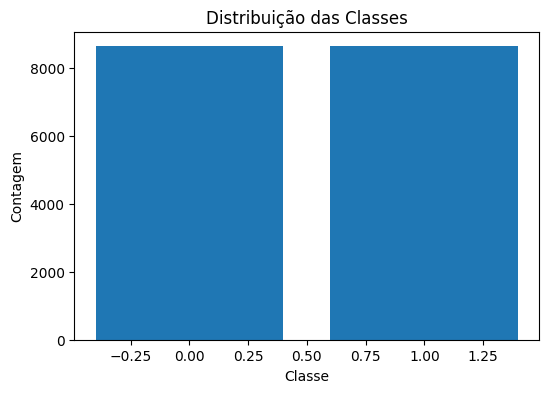

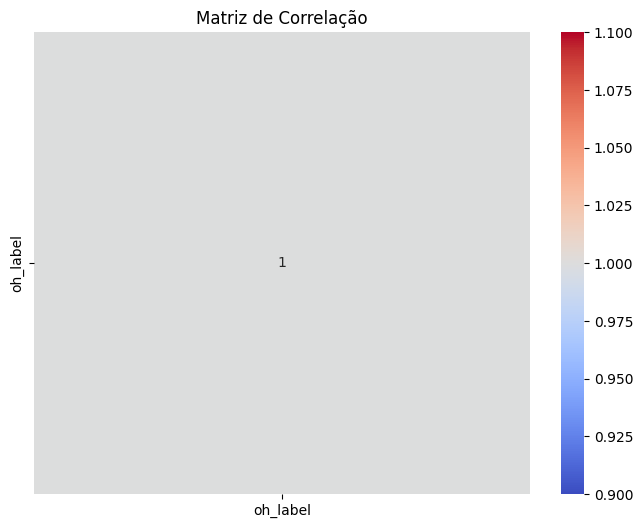

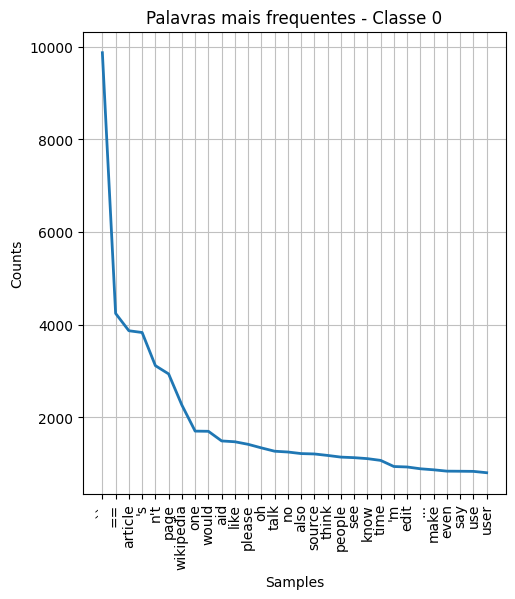

C:\Users\gerso\AppData\Local\Temp\ipykernel_22560\2843795902.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


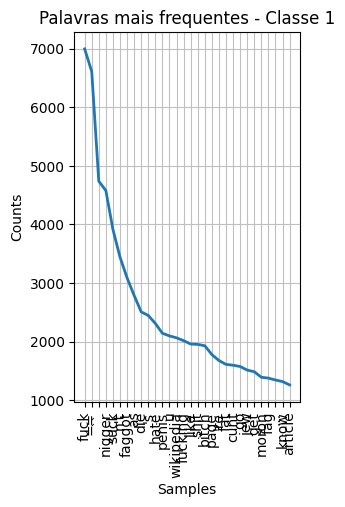

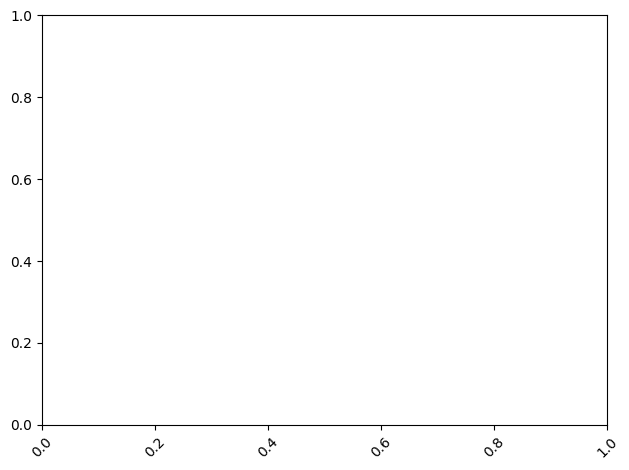

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist

# Gráfico de contagem de classes
class_counts = train['oh_label'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Distribuição das Classes')

# Gráfico de correlação
correlation_matrix = train.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')

# Gráfico de dispersão de palavras
freq_dist_class0 = FreqDist(train[train['oh_label'] == 0]['Normalized Tokens'].sum())
freq_dist_class1 = FreqDist(train[train['oh_label'] == 1]['Normalized Tokens'].sum())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
freq_dist_class0.plot(30, title='Palavras mais frequentes - Classe 0')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
freq_dist_class1.plot(30, title='Palavras mais frequentes - Classe 1')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()